# Generate Figure 2 of Kaiser et al. 2020 ( log(K/Ca) vs. log(Na/Ca) )

This is the same message at the beginning of all jupyter notebooks in this directory. 

If you don't have the below packages, you obviously need to install them for this to work. If it doesn't work still it's extremely likely you have an outdated version of one of the packages. Alternatively, some of the histogram functions actually rely on not being the most recent version because they changed from "normed" to something else from my recollection. Or perhaps it was the other way. I am aware this was poor decision-making, but it works (if you use the right version). ¯\\_(ツ)_/¯

Also pretty much all of these commands are copied and pasted from another Jupyter notebook I made but contained tons of tries at doing this stuff (and unrelated efforts) so that's why a lot of the variables seem unnecessary to use.

Ok, we basically need to follow the convention of Swan et al. 2019 and create arrows whose length is equal to some multiple of the "e-folding" time. 

In [1]:
from __future__ import print_function

import matplotlib
#matplotlib.use('pdf')
    
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from astropy.io import fits
from glob import glob
from astropy.time import Time
from astropy import coordinates as coords
from astropy import units as u
from astropy import constants as const
from astropy import convolution as conv
from astropy.table import Table, Column
import scipy.interpolate as scinterp
import time
import periodictable as pt

start = time.time()
print(start)
time_string=str(start).split('.')[0]

from mendeleev import O, Ca, Li, Na, Si, Fe, Mg, He
start = time.time()

#import wdatmos
import spec_plot_tools as spt
import cal_params as cp
import plot_spec as ps
import abundance_corrections as acorr
import interp_tau as itau
#print(os.getcwd())

1600098065.804941


No handles with labels found to put in legend.




no file_setting specificied


(116, 4, 27)
(4, 27, 116)
(116,)
(116,)
(27, 116)
(116,)
(116,)
(27, 116)
(116,)
(116,)
(27, 116)
(116,)
(116,)
(27, 116)


<Figure size 640x480 with 1 Axes>

In [2]:
plt.show()

In [3]:
figure_output_dir='/Users/BenKaiser/Desktop/GaiaJ1644m0449_paper/First_Revision/figures'

In [4]:
target_dir= '/Users/BenKaiser/Desktop/GaiaJ1644m0449_paper/'
os.chdir(target_dir)

In [5]:
wd_abund_file='temp_wd_abundances.csv'
lodders_abund_file='Lodders2009_solarsystem_abundances.csv'

In [6]:
wd_abund_table=Table.read(wd_abund_file)
lodders_table=Table.read(lodders_abund_file)
lodders_table.add_index('element')
wd_abund_table.add_index('name')



In [7]:
color_dict={
    'GaiaJ1644-0449':'r',
    'SDSSJ1330+6435':'darkviolet',
    'WDJ2356-209':'g'
}
step_dict={
    'GaiaJ1644-0449':5,
    'SDSSJ1330+6435':5,
    'WDJ2356-209':5
}

wd_marker='*'
met_marker='D'
met_color='#1ca1f2'
met_size=5
ci_size=10
wd_size=10
dp_alpha=0.5
ci_leg_size=9
arr_naca=[-0.4,-0.1]
alpha_range=[0.5,0.2]
arrow_segs=100
arrow_width=0.03
arrow_line=4
figure_text_size=6

In [8]:
def add_arrow(line, position=None, direction='right', size=20, color=None, slope=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1
    #xend=0.5*(xdata[end_ind]-xdata[start_ind])+xdata[start_ind]
    #yend=0.5*(ydata[end_ind]-ydata[end_ind])+ydata[start_ind]
    if slope is None:
        print('no slope...')
        xend=xdata[end_ind]
        yend=ydata[end_ind]
        xstart=xdata[start_ind]
        ystart=ydata[start_ind]
    else:
        #xend=0.5*(xdata[end_ind]-xdata[start_ind])+xdata[start_ind]
        xend=xdata[end_ind]
        #yend=slope*(xend-xdata[start_ind])+ydata[start_ind] #slope-intercept form that should work
        xstart=0.5*(xdata[start_ind]-xdata[end_ind])+xdata[end_ind]
        ystart=slope*(xstart-xdata[end_ind])+ydata[end_ind] #slope-intercept form that should work
    line.axes.annotate('',
        #xytext=(xdata[start_ind], ydata[start_ind]),
        xytext=(xstart,ystart),
        xy=(xdata[end_ind], ydata[end_ind]),
        #xy=(xend, yend),
        arrowprops=dict(arrowstyle="<|-", color=color),
        size=size
    )




In [13]:

def plot_wd_KCaNa(name, logg='default', teff='default', t_step=10, naca_min=-4.0, t_max=100, elements=["K","Ca","Na"], t_step_units='Myr',plot_type='line',SSP=True):
    """
    
    
    t_step=10, time in Myr of time-step for declining phase
    
    
    """
    
    string1= elements[0].lower()+'/'+elements[1].lower()
    string2=elements[2].lower()+'/'+elements[1].lower()
    #times= np.arange(0, t_max+t_step, t_step)
    
    
    target_row=wd_abund_table.loc[name]
    target_el1el2=target_row[string1]
    target_el3el2=target_row[string2]
    label=target_row['name']
    if logg=='default':
        logg=target_row['logg']
    else:
        pass
    if teff=='default':
        teff= target_row['teff']
    else:
        pass
    if SSP:
        #tau_el1=itau.extrapolate_tau_x_logg(teff, logg, elements[0])
        #tau_el2=itau.extrapolate_tau_x_logg(teff, logg, elements[1])
        #tau_el3=itau.extrapolate_tau_x_logg(teff, logg, elements[2])
        #target_el1el2=target_el1el2+tau_el2-tau_el1
        #target_el3el2=target_el3el2+tau_el2-tau_el3
        #plt.plot(target_el3el2,target_el1el2,marker='s')
        #plt.show()
        
        #target_el1el2, target_el3el2, el1el2_dist, el3el2_dist=acorr.easy_dist_ssp(target_row,elements, plot_all=False,tau_rand=True)
        #el1el2_err=np.std(el1el2_dist)
        #el3el2_err=np.std(el3el2_dist)
        plot_marker=met_marker
        target_el1el2, target_el3el2, el1el2_err, el3el2_err=acorr.easy_dist_ssp(target_row,elements, plot_all=False,tau_rand=True,n_points=int(1e6))
        label=label+' SSP'
    else:
        plot_marker=wd_marker
        el1el2_err=target_row[string2+'_err']
        el3el2_err=target_row[string1+'_err']
        
    if t_step_units != 'Myr':
        print("t_step_units is not Myr, meaning it's some diffusion timescale multiple")
        print('so t_step= ',t_step,"* tau_",t_step_units)
        tau_time= 10.**itau.extrapolate_tau_x_logg(teff, logg, t_step_units)
        tau_time=tau_time*1e-6 #converted to Myr
        t_step=t_step*tau_time
        t_max=t_max*tau_time
        print('New t_step:',t_step, 'Myr')
        print('New t_max:', t_max, 'Myr')
    else:
        pass
    if plot_type=='line':
        times= np.arange(-1*t_max-t_step, t_max+t_step, t_step)
        #dp_el1el2, dp_el3el2= acorr.el1el2_DP_el3el2_ftimes(teff, target_row['k/ca'], target_row['na/ca'],times, 'K', "Ca", "Na", logg=logg)
        dp_el1el2, dp_el3el2= acorr.el1el2_DP_el3el2_ftimes(teff, target_row[string1], target_row[string2],times, elements[0], elements[1], elements[2], logg=logg)
        line= plt.plot(dp_el3el2, dp_el1el2, marker='o', label="teff="+str(teff)+'K,logg='+str(logg), color=color_dict[name], alpha=dp_alpha)

        slope=(dp_el1el2-np.roll(dp_el1el2,1))/(dp_el3el2-np.roll(dp_el3el2,1))
        add_arrow(line[0],position=arr_naca[0], slope=slope[0])
        #print('Slope:', slope)
    elif ((plot_type=='arrow')and (target_row['name']!="WDJ2356-209")):
        times=t_step
        arrow_endy,arrow_endx=acorr.el1el2_DP_el3el2_ftimes(teff, target_row[string1], target_row[string2],times, elements[0], elements[1], elements[2], logg=logg)
        #print('arrow_endy',arrow_endy,'arrow_endx',arrow_endx)
        #plt.plot(arrow_endx,arrow_endy,marker='o')
        ypoints=np.linspace(target_el1el2,arrow_endy,arrow_segs)
        xpoints=np.linspace(target_el3el2,arrow_endx,arrow_segs)
        #dx=arrow_endx-target_el3el2
        #dy=arrow_endy-target_el1el2
        dx=arrow_endx-xpoints[-2]
        dy=arrow_endy-ypoints[-2]
        def get_segs(points):
            return np.vstack([points,np.roll(points,1)]).T[1:]
        x_segs=get_segs(xpoints)
        y_segs=get_segs(ypoints)
        #print('x_segs',x_segs)
        #color_array=np.empty_like(ypoints,dtype=str)
        #color_array[:]=color_dict[name]
        alpha_vals=np.linspace(alpha_range[0],alpha_range[1],arrow_segs)
        #print('alpha_vals',alpha_vals)
        for x,y,alpha in zip(x_segs, y_segs,alpha_vals):
            #plt.plot(x,y,color=color_dict[name],alpha=alpha,linewidth=arrow_line)
            plt.plot(x,y,color=color_dict[name],alpha=alpha)
        plt.arrow(xpoints[-2],ypoints[-2],dx,dy,color=color_dict[name],width=arrow_width, alpha=alpha_range[1],length_includes_head=True )
    else:
        print('\nplot_type not recognized', plot_type,'\n')
    print('\n\n',target_row['name'])
    if target_row['name']!='WDJ2356-209':
        pass
        #plt.text(target_el3el2,target_el1el2,target_row['name'])
    if target_row['name']=='GaiaJ1644-0449':
        plt.errorbar(target_el3el2,target_el1el2,xerr=el3el2_err,yerr=el1el2_err, marker=plot_marker, markersize=ci_size, color=color_dict[target_row['name']], linestyle='None')
        plt.errorbar(target_el3el2,target_el1el2,xerr=el3el2_err,yerr=el1el2_err, label=label, marker=plot_marker, markersize=ci_leg_size, color=color_dict[target_row['name']], linestyle='None')
    elif target_row['name']=='WDJ2356-209':
        print('\nskipping WDJ2356-209\n')
    else:
        plt.errorbar(target_el3el2,target_el1el2,xerr=el3el2_err,yerr=0.3, uplims=True, marker=plot_marker, markersize=wd_size, color=color_dict[target_row['name']],linestyle='None')
        plt.errorbar(target_el3el2,target_el1el2,label=label,uplims=True, marker=plot_marker, markersize=ci_leg_size, color=color_dict[target_row['name']],linestyle='None')
    #t_nouse, arr_start=acorr.el1el2_DP_el3el2(teff, target_row[string1],target_row[string2], arr_naca[0],elements[0],elements[1],elements[2],logg=logg)
    #print(t_nouse)
    #t_nouse, arr_end=acorr.el1el2_DP_el3el2(teff, target_row[string1],target_row[string2], arr_naca[1],elements[0],elements[1],elements[2],logg=logg)
    #print(t_nouse)
    #plt.arrow(arr_naca[0], arr_start , arr_naca[1], arr_end-arr_start, shape='full', lw=1, length_includes_head=True, head_width=.05)
    #plt.plot(arr_naca,[arr_start,arr_end],color='b',marker='o')
    return

In [14]:
#from Mashonkina et al. 2019 and the other Mashonkina et al. 2019/2020 paper that included thin disk stars as well.
npoints=100
FeH_thick= np.linspace(-1.5,-0.4,npoints)
FeH_halo=np.linspace(-2.6,-1.2,npoints)
FeH_thin= np.linspace(-0.73, 0.24, npoints)

#from later Mashonkina et al. 2019/2020 and our by-eye approximation of the trend
def get_CaFe_thin(FeH):
    slope=(0-0.24)/(0+0.7)
    #print(slope)
    return slope*FeH

#from Takeda 2020 for FGK dwarfs over the range 
def get_KFe_thin(FeH):
    #uncertainties: slope +/- 0.022, intercept +/- 0.005
    return -0.129*FeH -0.008

def get_KCa_thin(FeH):
    return get_KFe_thin(FeH)-get_CaFe_thin(FeH)

print(get_KCa_thin(np.min(FeH_thin)))

def plot_objects_KCaNa(do_timetravel=False):
    #plt.axvline(x=-0.68, linestyle=":", color='k', label='SDSSJ1636+1619 Det. Limit')
    various_naca_list=[
        -1.1,-2.55,
                       -0.4, -0.01, -0.64,0.0, 0.2, -0.74,
                       -0.58, -0.47, -1.25,
                      -0.28,-0.49, -0.33,-0.5,
                       #-0.06,
        #-0.04,-0.04,
                       0.15,#0.0,
                       #-1.19,-1.14,-1.08,-1.18,
                       #-0.38,
        -1.488, -1.707, -1.293,
                       -0.35,-0.62,0.10,0.01,
        -0.348,
        #-0.02,
                       -1.56,-0.29
                      ]
    various_kca_list=[
        -2.3,-4.1,
                      -1.7, -1.2,-1.86,-0.3, -1.5, -2.0,
                      -1.67, -1.18, -1.98,
                     -1.53,-1.7,-1.63,-1.76,
                      #-1.18,
        #-1.15,-1.17,
                      -1.0,#-1.15,
                      #-1.87,-1.74,-1.47,-2.0,
                      #-0.96,
        -2.578, -2.861, -2.264,
                      -1.60,-1.80,-1.06,-1.35,
        -1.7997,
        #-1.22,
                      -3.03,-2.62
                     ]
    name_list=[
        'Eucrite', 'Angra dos Reis',
               'Bulk Mars','CI Chondrite', 'Bulk Earth', "Earth\nContinental\nCrust","Comet Halley",
              "Earth Primitive Mantle", 
                "Sherg.", "Chassigny", "Nakhla",
              "CM","CV","CO","CK",
               #"H",
        #"L","LL",
               "EH",#"EL",
               #"lunar\nsoil","lunar\nbreccia","lunar\nHigh-K\nrock","lunar\nLow-K\nrock",
               #"Knippa\nbasalt",
        "Bulk Moon","Bulk Lunar Silicates", "Lunar Highland Crust",
               "CR","CH","R","Acap.",
        "Oceanic Crust",
        #"K",
               "Binda","Johnstown"
              ]
    P67_vals=[1.17, -0.41, 0.54, 0.38]
    max_KCa_off_thin=get_KCa_thin(np.nanmin(FeH_thin))

    #plt.scatter(various_naca_list,various_kca_list, color='magenta', label='various bodies')
    index_val=0
    for naca, kca, name in zip(various_naca_list, various_kca_list, name_list):
        if name=='CI Chondrite':
            #print('CI Chondrite caught')
            #plt.scatter(naca,kca, color=met_color, marker=met_marker, s=ci_size)
            plt.errorbar(naca,kca, color=met_color, marker=met_marker, markersize=ci_size, linestyle='None')
        elif index_val==0:
            #plt.scatter(naca,kca, color=met_color,marker=met_marker , label='[Fe/H]_form=0')
            plt.errorbar(naca,kca, color=met_color,marker=met_marker , label='Solar System Body',linestyle='None',markersize=met_size)
            if do_timetravel:
                plt.scatter(naca,kca+max_KCa_off_thin, color='b', label='[Fe/H]_form=-0.73')
            else:
                pass
        else:
            #print('else statement')
            #print(name)
            #print('def in else statement\n')
            #plt.scatter(naca,kca, color=met_color, marker=met_marker)
            plt.errorbar(naca,kca, color=met_color, marker=met_marker, linestyle='None',markersize=met_size)
            if do_timetravel:
                plt.scatter(naca,kca+max_KCa_off_thin, color='b')
            else:
                pass
        plt.text(naca, kca, name,fontdict={'size':figure_text_size})
        index_val+=1
    
    
    plt.errorbar(P67_vals[0],P67_vals[1], xerr= P67_vals[2], yerr=P67_vals[3], color=met_color, marker=met_marker)
    if do_timetravel:
        plt.errorbar(P67_vals[0],P67_vals[1]+max_KCa_off_thin, xerr= P67_vals[2], yerr=P67_vals[3], color='b', marker='o')
    plt.text(P67_vals[0], P67_vals[1], "Comet 67P",fontdict={'size':figure_text_size})
    return






-0.16411571428571428




 GaiaJ1644-0449
4219.745166280546 7.959316903845385
4219.745166280546 7.959316903845385
4219.745166280546 7.959316903845385
tau_K-tau_Ca -0.030323634945992252 +/- 0.20102177465719656
tau_Na-tau_Ca 0.3480173224177363 +/- 0.20806831173860385
target_ssp K Ca -1.4099288890415331
target_ssp Na Ca -0.2750074670470309
dist ssp K Ca -1.4097866229101945 -1.4095057196736165 0.2768481051873732
dist ssp Na Ca -0.26843161846897134 -0.26786177120567717 0.26886041205398115
t_step_units is not Myr, meaning it's some diffusion timescale multiple
so t_step=  5 * tau_ Ca
New t_step: 17.4506343576774 Myr
New t_max: 34.9012687153548 Myr
K log tau 6.512770103566982
Ca log tau 6.542841214525449
Na log tau 6.89784868157248


 GaiaJ1644-0449


 SDSSJ1330+6435
4894.990562389541 8.110118680299593
4894.990562389541 8.110118680299593
4894.990562389541 8.110118680299593
tau_K-tau_Ca -0.0626105106788441 +/- 0.20066607137822925
tau_Na-tau_Ca 0.37643189786896336 +/- 0.20176595146562765
target_ssp K Ca -0.23665286619

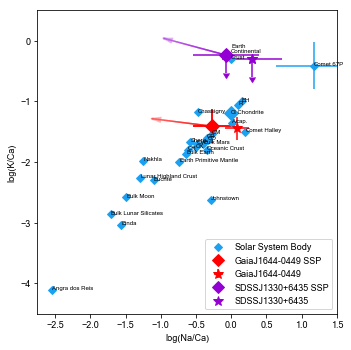

In [15]:
spt.initiate_science_plot()

wd_name='SDSSJ1330+6435'
j1644_row=wd_abund_table.loc[wd_name]
plot_type='arrow'
#plt.figure(figsize=(7.25,7.25),constrained_layout=True)
plt.figure(figsize=(4.75,4.75),constrained_layout=True)


#naca_line=np.linspace(-4, 0.0, 40)
#t_step=1
t_max=10
count=0
plot_objects_KCaNa(do_timetravel=False)


for j1644_row in wd_abund_table:
    
    print('\n\n',j1644_row['name'])
    if count==3:
        break
    t_step=step_dict[j1644_row['name']]
    plot_wd_KCaNa(j1644_row['name'], logg='default', t_step=t_step, naca_min=-4.0, t_max=t_max, t_step_units='Ca', plot_type=plot_type)
    #plt.text(j1644_row['na/ca'],j1644_row['k/ca'],j1644_row['name'])
    #if j1644_row['name'] != 'WDJ2356-209': 
        #plot_wd_KCaNa(j1644_row['name'], logg='default', t_step=t_step, naca_min=-4.0, t_max=t_max, t_step_units='Ca', plot_type=plot_type)
        #plt.text(j1644_row['na/ca'],j1644_row['k/ca'],j1644_row['name'])
    if j1644_row['name']=='GaiaJ1644-0449':
        plt.errorbar(j1644_row['na/ca'],j1644_row['k/ca'],xerr=j1644_row['na/ca_err'],yerr=j1644_row['k/ca_err'], label='GaiaJ1644-0449', marker=wd_marker, markersize=wd_size, color=color_dict[j1644_row['name']],linestyle='None')
    elif j1644_row['name']=='WDJ2356-209':
        print('\nskipping WDJ2356-209\n')
    else:
        plt.errorbar(j1644_row['na/ca'],j1644_row['k/ca'],xerr=j1644_row['na/ca_err'],yerr=0.3, uplims=True, marker=wd_marker, color=color_dict[j1644_row['name']], markersize=wd_size,linestyle='None')
        plt.errorbar(j1644_row['na/ca'],j1644_row['k/ca'], label=j1644_row['name'], marker=wd_marker, color=color_dict[j1644_row['name']], markersize=wd_size,linestyle='None')


    #acorr.el1el2_DP_el3el2_ftimes(j1644_row['teff'], j1644_row['li/ca'], j1644_row['na/ca'],1, 'Li', "Ca", "Na", logg=j1644_row['logg'])
    count+=1
#plot_wd_KCaNa(wd_name, teff=4200, t_step=t_step, naca_min=-4.0, t_max=t_max)
#plt.errorbar(j1644_row['na/ca'],j1644_row['k/ca'],xerr=j1644_row['na/ca_err'],yerr=0.3, uplims=True,label=j1644_row['name'], marker=wd_marker, color=color_dict[j1644_row['name']], markersize=wd_size)

plt.xlim(-2.75,1.5)
#plt.ylim(-2,0.0)
plt.ylim(-4.5,0.5)



#plt.legend(loc='best')
#plt.title(wd_name+' Declining Phase abundances '+str(t_step)+" Myr increments")
plt.xlabel('log(Na/Ca)',fontdict={'name':'Microsoft Sans Serif','size':9})
plt.ylabel('log(K/Ca)')

print(os.getcwd())
os.chdir(figure_output_dir)
print(os.getcwd())
start = time.time()
print(start)
time_string=str(start).split('.')[0]

plt.legend(loc='lower right')
#plt.savefig('figure2_'+time_string+'.pdf')#plt.grid(True)

plt.show()







In [16]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [18]:
np.log10(3.621980492301957*1e6/5)

5.85997610257288

In [19]:
np.log10(17.4506343576774*1e6/5)

6.542841214525449

In [20]:
6.26-5.86

0.39999999999999947

In [21]:
6.56-6.32

0.23999999999999932

In [22]:
0.3999-0.23999

0.15990999999999997